In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from sklearn.model_selection import train_test_split
import seaborn as sn
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
!pip install scienceplots
from google.colab import files
import scienceplots
mp.style.use(['science','ieee','grid','no-latex'])

In [ ]:
def save_model(model,name):
  model.save(f'{name}.h5')
  files.download(f'{name}.h5')

In [ ]:
mp.rcParams['lines.marker']='.'
mp.rcParams['lines.linestyle']='-'
mp.rcParams['lines.markersize']=6
mp.rcParams['lines.linewidth']=1.5
mp.rcParams['figure.figsize']=(6, 3)
mp.rcParams['figure.dpi']=100

**Extracting the first 120000 readings(takes some time):-**

In [ ]:
full=pd.read_csv('/content/PVGen.csv', on_bad_lines='skip')
full=full.iloc[0:190000,:]

**Creating a seperate column to store only the dates:-**

In [ ]:
dates = pd.to_datetime(full['Time'], format='%d-%m-%Y %H:%M', errors='coerce').dt.strftime('%m-%d-%y').to_numpy()

In [ ]:
full['Date']=dates

In [ ]:
full

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,Date
0,01-01-2017 00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,01-01-17
1,01-01-2017 00:15,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,01-01-17
2,01-01-2017 00:30,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,01-01-17
3,01-01-2017 00:45,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1,01-01-17
4,01-01-2017 01:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1,01-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189995,22-06-2022 02:45,42,2.9,8.0,1013,99,2.4,0.0,0.0,67,1,30,1020,0.03,3,2,6,06-22-22
189996,22-06-2022 03:00,60,7.3,8.3,1013,100,2.0,0.0,0.0,55,1,45,1020,0.04,3,3,6,06-22-22
189997,22-06-2022 03:15,79,12.9,8.3,1013,100,2.0,0.0,0.0,55,1,60,1020,0.06,3,3,6,06-22-22
189998,22-06-2022 03:30,98,17.0,8.3,1013,100,2.0,0.0,0.0,55,1,75,1020,0.07,3,3,6,06-22-22


In [ ]:
buffer=np.array([])
start=0
while(start<190000):  #0-95 same date
  date=dates[start]
  mask_dataframe=full['Date']==date
  filtered_dataframe=full[mask_dataframe]
  mean=np.mean(filtered_dataframe['Energy delta[Wh]'])
  buffer=np.append(buffer,mean)
  start=start+96

In [ ]:
week_data=np.array([])
start=0
while(start<len(buffer)):
  date=dates[start]
  mean=np.mean(buffer[start:start+7])
  week_data=np.append(week_data,mean)
  start=start+7


In [ ]:
index=np.array(range(0,len(week_data)))
dict_data={'index':index,'week_data':week_data}
df=pd.DataFrame(dict_data)

**<h1><u>ARIMA MODEL</u></h1>**


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
X_train,X_test,y_train,y_test=train_test_split(df['index'],df['week_data'],test_size=54,shuffle=False)


<Axes: xlabel='index', ylabel='week_data'>

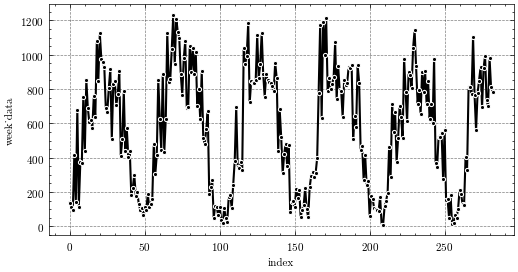

In [ ]:
sn.lineplot(data=df,x='index',y='week_data')

**Using PMDARIMA to give the optimal value of differencing order(d) using ndiffs() function:-**

In [ ]:
!pip install pmdarima

In [ ]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train.diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -15.358028136430141
p-value: 3.644355383330194e-28
Critical Value (1%): -3.4596204846395824
Critical Value (5%): -2.8744153028455948
Critical Value (10%): -2.5736320761218576


<Figure size 300x300 with 0 Axes>

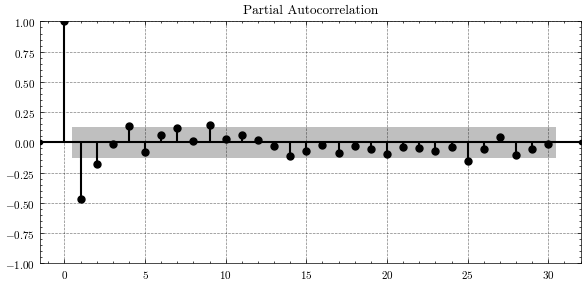

In [ ]:
mp.figure(figsize=(3,3),dpi=100)
plot_pacf(pd.Series(y_train).diff().dropna(),
          lags=30,
          method='ywm')
mp.tight_layout()
mp.show()
#AR terms can be 1

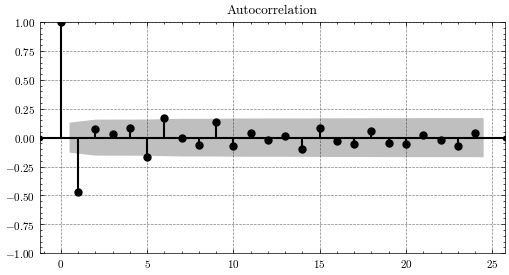

In [ ]:
plot_acf(pd.Series(y_train).diff().dropna());
#MA term can be 1

**As this is seasonal data we use Seasonal ARIMA with a seasonal differencing term of 52 as the data is weekly:**

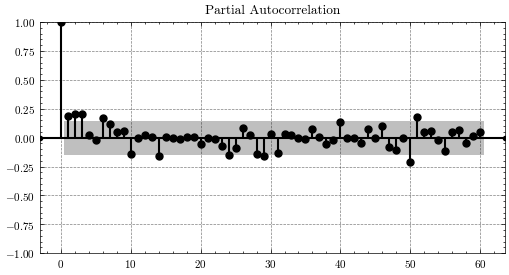

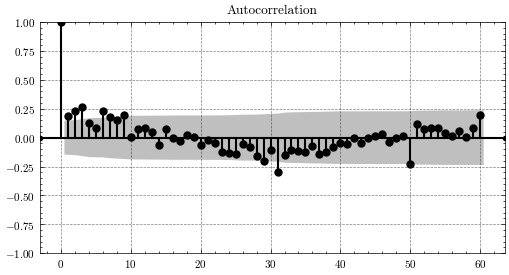

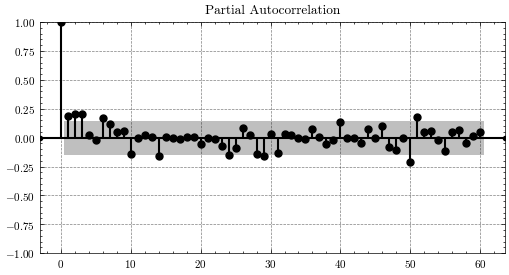

In [ ]:
y_seasonal_diff = y_train.diff(50).dropna()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_seasonal_diff, lags=60)
plot_pacf(y_seasonal_diff, lags=60)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(y_train,order=(1,1,1),seasonal_order=(2,1,3,50))
result=model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
y_train_fit = result.predict(start=y_train.index[0],
                               end=y_train.index[-1],
                               typ='levels')

In [ ]:
mp.figure(figsize=(6,3),dpi=100)
sn.lineplot(y_train_fit,label='predicted',linestyle='-',marker='.')
sn.lineplot(y_train,label='actual')

In [ ]:
steps = len(X_test)
final_result_arima = result.forecast(steps=steps)
final_result_arima.index = X_test.index  # align it with actual test data

In [ ]:
len(X_test)

# **The ARIMA model's inference on the test data:**#

In [ ]:
mp.figure(figsize=(6,3),dpi=100)
sn.lineplot(final_result_arima,label='predicted',linestyle='-',marker='.',color='red')
sn.lineplot(y_test,label='actual',color='black')
mp.savefig("arima.svg", format='svg')

# <u>**Transformer**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
data = df['week_data']
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
SEQ_LEN=25
BATCH_SIZE=64
EPOCHS=30
D_MODEL=64
LR=0.001
split_idx=int(229)
train_data=scaled_data[:split_idx]
test_data=scaled_data[split_idx-SEQ_LEN:]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class PVGenDataset(Dataset):
    def __init__(self, data, seq_len):
        self.X,self.y=[],[]
        for i in range(len(data)-seq_len):
            self.X.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len])
        self.X=torch.tensor(np.array(self.X),dtype=torch.float32)
        self.y=torch.tensor(np.array(self.y),dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset=PVGenDataset(train_data, SEQ_LEN)
test_dataset=PVGenDataset(test_data, SEQ_LEN)
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=1, shuffle=False)
class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout=0.1):
        super().__init__()
        self.pos_encoder=nn.Parameter(torch.randn(SEQ_LEN, d_model))
        self.input_fc=nn.Linear(1, d_model)
        encoder_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer=nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder=nn.Linear(d_model, 1)
    def forward(self,x):
        x = self.input_fc(x)+self.pos_encoder
        x = self.transformer(x)
        return self.decoder(x[:,-1,:])

model = TransformerModel(d_model=D_MODEL, nhead=4, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
criterion = nn.MSELoss()
# Training loop
for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    model.train()
    losses = []
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]",leave=False)
    for xb, yb in loop:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out.squeeze(),yb.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {np.mean(losses):.6f}")
# Evaluation on test set
model.eval()
predictions_transformer = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        predictions_transformer.append(out.item())
        actuals.append(yb.item())

# Inverse transform predictions
predictions_transformer = scaler.inverse_transform(np.array(predictions_transformer).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Plot actual vs predicted
mp.figure(figsize=(6,3),dpi=100)
mp.plot(actuals, label='actual')
mp.plot(predictions_transformer, label='predicted',color='blue')
mp.xlabel("Time Step")
mp.ylabel("PV Generation")
mp.title("Actual vs Predicted PV Generation (Test Set)")
mp.legend()
mp.grid(True)
mp.tight_layout()
mp.savefig("transformer.svg", format='svg')
mp.show()


In [ ]:
len(predictions_transformer)

**<h1><u>LSTM Model</u></h1>**

**Importing libraries for creation of network:-**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

**Creating the network:-**

In [ ]:
model=Sequential()
model.add(LSTM(700,activation='relu',input_shape=(7,1),return_sequences=True))
model.add(LSTM(500,activation='relu',return_sequences=True))
model.add(LSTM(200,activation='relu',return_sequences=True))
model.add(LSTM(100,activation='relu'))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mae')

## **Creating Training Data:-**

**Each output corresponds to the 52 values recorded before it taken as input:-**

In [ ]:
inputs=[]
outputs=[]
for i in range(0, len(df) - 7):
    inputs.append(df['week_data'][i:i+7])
    outputs.append(df['week_data'][i+7])
inputs=np.array(inputs)
outputs=np.array(outputs)


In [ ]:
inputs.shape

In [ ]:
outputs.shape

In [ ]:
params=EarlyStopping(monitor='val_loss',patience=50)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(inputs,outputs,test_size=54,shuffle=False)


In [ ]:
len(X_test)

In [ ]:
history=model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),callbacks=[params])
model.save('lstm.h5')


In [ ]:
sn.lineplot(history.history['loss'],label='training loss',color='red')
sn.lineplot(history.history['val_loss'],label='validation loss',color='blue')

In [ ]:
prediction_lstm=model.predict(X_test)

In [ ]:
prediction_lstm.shape

In [ ]:
preds=prediction_lstm.flatten()

In [ ]:
preds

In [ ]:
y_test=y_test.flatten()

#**The LSTM model's inference on the test data:-**

In [ ]:
index=np.array(range(0,len(preds)))
mp.figure(figsize=(6,3),dpi=100)
sn.lineplot(x=index,y=preds,label='prediction',color='green')
sn.lineplot(x=index,y=y_test,label='actual',color='black')
mp.savefig("lstm.svg", format='svg')

In [ ]:
len(y_test)

**<h1><u>VAR Model</u></h1>**

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

**<h3>As the VAR Model uses at least two features to make predictions we will use the dayLength as second feature:- </h3>**

In [ ]:
buffer_e=np.array([])
buffer_r=np.array([])
start=0
while(start<len(dates)):  #0-95 same date
  date=dates[start]
  mask_dataframe=full['Date']==date
  filtered_dataframe=full[mask_dataframe]
  mean_e=np.mean(filtered_dataframe['Energy delta[Wh]'])
  mean_r=np.mean(filtered_dataframe['dayLength'])
  buffer_e=np.append(buffer_e,mean_e)
  buffer_r=np.append(buffer_r,mean_r)
  start=start+96

In [ ]:
week_data_e=np.array([])
week_data_r=np.array([])
start=0
while(start<len(buffer_e)):
  date=dates[start]
  mean_e=np.mean(buffer_e[start:start+7])
  mean_r=np.mean(buffer_r[start:start+7])
  week_data_e=np.append(week_data_e,mean_e)
  week_data_r=np.append(week_data_r,mean_r)
  start=start+7


In [ ]:
index=np.array(range(0,len(week_data_e)))
dict_data={'week_data':week_data_e,'day_data':week_data_r}
df=pd.DataFrame(dict_data)

**Creating the model:-**

In [ ]:
diff_e=df['week_data'].dropna()
diff_r=df['day_data']

In [ ]:
sn.lineplot(diff_e,color='red')
sn.lineplot(diff_r,color='blue')
df['week_data']=diff_e
df['day_data']=diff_r

In [ ]:
from sklearn.model_selection import train_test_split
X_train,x_test=train_test_split(df,test_size=54,shuffle=False)

In [ ]:
X_train

In [ ]:
model=VAR(X_train)

**<h3>Past 25 values will be used to make predictions</h3>**

In [ ]:
results=model.fit(maxlags=25)

In [ ]:
forecast = results.forecast(x_test.values, steps=len(x_test))
forecast = np.array(forecast)


In [ ]:
prediction_var=np.array([])
for a in forecast:
  prediction_var=np.append(prediction_var,a[0])


In [ ]:
x_test['indices']=range(0,len(x_test))

In [ ]:
prediction_var_df=pd.DataFrame([])
prediction_var_df['prediction']=prediction_var
prediction_var_df['indices']=range(0,len(x_test))

In [ ]:
prediction_var_df

# **The VAR Model's inference on test data:-**

In [ ]:
mp.figure(figsize=(6,3))
sn.lineplot(data=x_test,y='week_data',x='indices',legend=True,color='black')
sn.lineplot(data=prediction_var_df,y='prediction',x='indices',legend=True,color='brown')
mp.savefig("var.svg", format='svg')

In [ ]:
len(y_test)

**<h1><u>Accessing the predictions of the three models</h1></u>**

In [ ]:
final_result_arima

In [ ]:
final_result_arima.shape

In [ ]:
prediction_arima=final_result_arima.to_numpy()

In [ ]:
sn.lineplot(prediction_arima,label='predicted',color='red')
sn.lineplot(y_test,color='black')

In [ ]:
prediction_lstm=prediction_lstm.flatten()

In [ ]:
sn.lineplot(prediction_lstm,label='predicted',color='blue')
sn.lineplot(y_test,color='black')

In [ ]:
sn.lineplot(prediction_var,label='predicted',color='green')
sn.lineplot(y_test,color='black')

In [ ]:
sn.lineplot(predictions_transformer,label='predicted',color='lime')
sn.lineplot(y_test,color='black')

In [ ]:
prediction_combined=np.array([])
for i in range(0,54):
  comb=[prediction_arima[i],prediction_lstm[i],prediction_var[i],predictions_transformer[i]]
  prediction_combined=np.append(prediction_combined,[comb])
prediction_combined=prediction_combined.reshape(54,4)
prediction_combined.shape

**<h2>Combining results using Simple Average:-</h2>**

In [ ]:
predictions_meaned=np.array([])
for i in range(0,54):
  predictions_meaned=np.append(predictions_meaned,np.mean([prediction_combined[i][0],prediction_combined[i][1],prediction_combined[i][2],prediction_combined[i][3]]))
print(predictions_meaned)
len(predictions_meaned)

In [ ]:
y_test_df=pd.DataFrame(y_test)
y_test_df['index']=range(0,len(y_test))
y_test_df

# **The inference of Simple Mean Ensemble model on dataset:**

In [ ]:
sn.lineplot(y_test,color='black')
sn.lineplot(predictions_meaned,label='predicted',color='silver')
mp.savefig("simple_mean.svg", format='svg')

In [ ]:
loss_mse=mean_squared_error(y_test,predictions_meaned)
difference=np.absolute(y_test-predictions_meaned)
loss_mae=np.mean(difference)
print(loss_mse)
print(loss_mae)

**<h2>Combining results using CNN model:-</h2>**

In [ ]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Input



In [ ]:
prediction_combined.shape

In [ ]:
X_train_ens,X_test_ens,y_train_ens,y_test_ens=train_test_split(prediction_combined,y_test,test_size=0.2,shuffle=False)

In [ ]:
from tensorflow.keras.regularizers import l2

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001), input_shape=(4, 1)), # Changed input_shape to (4, 1)
    Conv1D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(32, activation='relu'), # This dense layer expects 32 features, so the previous layer output should match.
    Dense(1)  # Output layer
])
cnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
cnn_model.fit(X_train_ens,y_train_ens,epochs=200,validation_data=(X_test_ens, y_test_ens))

In [ ]:
prediction_cnn=cnn_model.predict(prediction_combined)

In [ ]:
prediction_cnn=prediction_cnn.flatten()

In [ ]:
prediction_cnn.shape

In [ ]:
y_test.shape

# **The inference of CNN Ensemble model on dataset:**

In [ ]:
sn.lineplot(y_test,color='black')
sn.lineplot(prediction_cnn,label='predicted',color='magenta')
mp.savefig("cnn.svg", format='svg')

In [ ]:
loss_mse=mean_squared_error(y_test,prediction_cnn)
difference=np.absolute(y_test-prediction_cnn)
loss_mae=np.mean(difference)
print(loss_mse)
print(loss_mae)

**<h2>Combining results using MLP model:-</h2>**

In [ ]:
mlp_model = Sequential([
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dense(300, activation='relu'),
    BatchNormalization(),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model (Adam optimizer with MSE loss)
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
mlp_model.summary()

In [ ]:
prediction_combined.shape

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
# Fit the MLP model with the reshaped data
mlp_model.fit(
    prediction_combined,
    y_test,
    epochs=300,
    validation_data=(X_test_ens, y_test_ens),
    callbacks=[early_stopping]
)

In [ ]:

mlp_loss, mlp_mae = mlp_model.evaluate(X_test_ens, y_test_ens)
print(f"MLP Test Loss (MSE): {mlp_loss}")
print(f"MLP Test MAE: {mlp_mae}")

In [ ]:
mlp_predictions = mlp_model.predict(prediction_combined)

In [ ]:
mlp_predictions=mlp_predictions.flatten()

# **The inference of the MLP Ensemble Model on Dataset:**

In [ ]:
sn.lineplot(y_test,color='black')
sn.lineplot(mlp_predictions,label='predicted',color='darkgoldenrod')
mp.savefig("mlp.svg", format='svg')

In [ ]:
mlp_loss, mlp_mae = mlp_model.evaluate(X_test_ens, y_test_ens)
print(f"MLP Test Loss (MSE): {mlp_loss}")
print(f"MLP Test MAE: {mlp_mae}")

**<h1>Comparing all the predictions:-</h1>**

In [ ]:
colors = {
    "Actual": "black",
    "Ensemble Model:Simple Mean": "#E69F00",   # orange
    "Single Model:Transformer": "#56B4E9",     # sky blue
    "Ensemble Model:CNN": "#009E73",          # green
    "Ensemble Model:MLP": "#F0E442",          # yellow
    "Single Model:ARIMA": "#0072B2",          # blue
    "Single Model:LSTM": "#D55E00",           # reddish orange
    "Single Model:VAR": "#CC79A7",            # pink
}

figure = mp.figure(figsize=(20,10))

sn.lineplot(x=range(len(y_test)),y=y_test,label="Actual", color=colors["Actual"])
sn.lineplot(x=range(len(predictions_meaned)),y=predictions_meaned, label="Ensemble Model:Simple Mean", color=colors["Ensemble Model:Simple Mean"])
sn.lineplot(x=range(len(predictions_transformer)),y=predictions_transformer, label="Single Model:Transformer", color=colors["Single Model:Transformer"])
sn.lineplot(x=range(len(prediction_cnn)),y=prediction_cnn, label="Ensemble Model:CNN", color=colors["Ensemble Model:CNN"])
sn.lineplot(x=range(len(mlp_predictions)),y=mlp_predictions, label="Ensemble Model:MLP", color=colors["Ensemble Model:MLP"])
sn.lineplot(x=range(len(prediction_arima)),y=prediction_arima, label="Single Model:ARIMA", color=colors["Single Model:ARIMA"])
sn.lineplot(x=range(len(prediction_lstm)),y=prediction_lstm, label="Single Model:LSTM", color=colors["Single Model:LSTM"])
sn.lineplot(x=range(len(prediction_var)),y=prediction_var, label="Single Model:VAR", color=colors["Single Model:VAR"])
mp.savefig("comparison.svg", format='svg')
mp.title("Comparison of All Models")
mp.legend(loc='upper right')
mp.grid(True)

In [ ]:

all_loss_mse=[mean_squared_error(y_test,predictions_meaned),mean_squared_error(y_test,prediction_cnn),mean_squared_error(y_test,mlp_predictions),mean_squared_error(y_test,prediction_arima),mean_squared_error(y_test,prediction_lstm),mean_squared_error(y_test,prediction_var),mean_squared_error(y_test,predictions_transformer)]


In [ ]:
all_loss_mse

In [ ]:
mp.ylabel('Mean Squared Errors')
mp.xlabel('Model')
sn.barplot(x=['Simple Mean','CNN','MLP','ARIMA','LSTM','VAR','Transformer'],y=all_loss_mse,palette='Set2')
mp.savefig("bars.svg", format='svg')